# Solving meta decision trees

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.5)
import itertools as it
from collections import Counter, defaultdict, deque
from toolz import memoize
from random import choice

In [2]:
# Plotting decision trees
from IPython.display import display
from meta_tree import MetaTree
from IPython.display import Image
COLOR = {None: 'grey', np.inf: 'grey', 1: '#dd4444', 0: '#5555ee'}
from graphviz import Digraph
def draw_tree(state):
    dot = Digraph()
    for x, ys in enumerate(mt.tree):
        c = COLOR[state[x]]
        dot.node(str(x), style='filled', color=c)
        for y in ys:
            dot.edge(str(x), str(y))
    display(dot)

# Solving an MDP with recursion and memoization

We can solve an MDP exactly by recursively applying the Bellman equations.
This solution is easy to code because it maps directly onto the mathematical
notation. However, in non-tree-structured MDPS (perhaps counterintuitively, including the MetaTree),
this approach will recompute the value of a state every time it is encountered. However,
by memoizing results, we avoid this recomputation. I believe the algorithm ends up performing the
same computations (in the same order) as backward induction.

To get a sense of how much of a benefit memoization gives, solving `MetaTree(branch=2, depth=2)`
requires evaluating `V` 75973 times without memoization and 729 times with memoization. You can
ignore the `hash_state` and `actions` parameters for now.

In [4]:
def solve(mdp, hash_state=None, actions=None):
    """Returns Q, V, pi, and computation data for an mdp."""
    if actions is None:
        actions = mdp.actions
    info = {  # track number of times each function is called
        'q': 0,
        'v': 0
    }
    
    def hash_key(args, kwargs):
        s = args[0]
        if s is None:
            return s
        else:
            return hash_state(args[0])

    if hash_state is None:
        hash_key = None

    @memoize
    def Q(s, a):
        info['q'] += 1
        return sum(p * (r + V(s1)) for p, s1, r in mdp.results(s, a))

    @memoize(key=hash_key)
    def V(s):
        if s is None:
            return 0
        info['v'] += 1
        return max(Q(s, a) for a in actions(s))
    
    @memoize
    def pi(s):
        return max(actions(s), key=lambda a: Q(s, a))
    
    return Q, V, pi, info

mt = MetaTree(2, 2, cost=-0)
Q, V, pi, info = solve(mt)  # note: no computation actually happens here.
print('Value:', V(mt.init))  # calling V(mt.init) runs the algorithm
print('Computations:', info)

Value: 2.09375
Computations: {'v': 729, 'q': 2187}


In [4]:
%%timeit
Q, V, pi, info = solve(mt)  # note: no computation actually happens here.
V(mt.init)

100 loops, best of 3: 15.7 ms per loop


We can see that the policy does reasonable things by executing a few episodes.

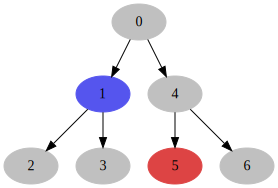

actions: [1, 5, 'TERM']
reward: 1.8


In [48]:
def run_episode(mdp, pi, s=None):
    """Runs a single random episode of an mdp with policy pi."""
    if s is None:
        s = mdp.init
    acts = []
    states = []
    reward = 0
    while True:
        a = pi(s)
        states.append(s)
        p, s, r = choice(mdp.results(s, a))
        acts.append(a)
        reward += r
        if a is mdp.term_action:
            draw_tree(states[-1])
            return acts, reward

actions, reward = run_episode(mt, pi)
print('actions:', actions)
print('reward:', reward)

# Reducing the state space
To improve efficiency, we can reduce the state space by treating isomorphic states
as identical. In the tree shown below, state 3 has been observed to have value 1.
However, intuitively, we would be in the same position if states 2, 5, or 6 were 
observed to have value 1 instead.

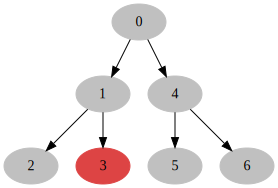

In [49]:
s1 = list(mt.init)
s1[3] = 1
draw_tree(s1)

Our algorithm can be more efficient if it can collapse across states that are functionally
identical. We can do this with a hash function that maps functionally identical states
to the same value. To that end, we create a hash function that sorts the tree. The intuition is that
the ordering of children of a given node is arbitrary. Thus, we break the symmetry by specifying a 
fixed ordering. The code is currently hardcoded for binary trees, but this could be changed. In the image
below, the top tree is an input state and the bottom is the hashed (sorted) version.

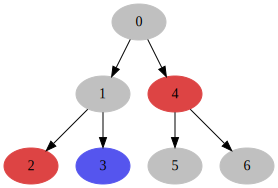

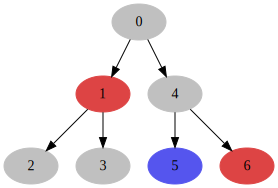

In [50]:
def sort_tree(mt, state):
    """Breaks symmetry between belief states.
    
    This is done by enforcing that the knowldge about states at each
    depth be sorted by [0, 1, UNKNOWN]
    """
    state = list(state)
    for i in range(len(mt.tree) - 1, -1, -1):
        if not mt.tree[i]:
            continue  # 
        c1, c2 = mt.tree[i]
        if not (mt.subtree(state, c1) <= mt.subtree(state, c2)):
            diff = c2 - c1
            for j in range(c1, c2):
                state[j], state[j+diff] = state[j+diff], state[j]
    return tuple(state)

state = list(mt.init)
state[4] = 1
state[2] = 1
state[3] = 0
draw_tree(state)
draw_tree(sort_tree(mt, state))

We see below that this method does not change the computed value, but it does reduce
the number of computations we perform. This is due to the reduction in the effective
number of states.

In [51]:
def evaluate(name, **kwargs):
    Q, V, pi, info = solve(mt, **kwargs)
    print('{:-^40}'.format(' ' + name + ' '))
    print('Value:', V(mt.init))
    print('Computations:', info)

evaluate('naive')
evaluate('hash states', hash_state=lambda s: sort_tree(mt, s))
print()
beliefs = list(it.product((mt.unknown, *mt.outcomes), repeat=len(mt.tree)))
print('# belief states:', len(beliefs))
non_sym = set(sort_tree(mt, s) for s in beliefs)
print('# non-symmetric:', len(non_sym))

---------------- naive -----------------
Value: 1.80625
Computations: {'v': 729, 'q': 2187}
------------- hash states --------------
Value: 1.80625
Computations: {'v': 171, 'q': 513}

# belief states: 2187
# non-symmetric: 513


# Reducing the action space

Reducing the state space helps us avoid re-evaluating functionally identical
states. However, the algorithm will still execute many functionally identical
computations before discovering that they have identical outcomes. We can
avoid this by pruning the computations we consider making at each step.
Following similar logic to the state-space reduction, when there are two
functionally identical nodes in the tree, we never select the one with the
higher index. To accomplish this, we search through the tree, identifying
possible computations along the way. When we come to a node whose children have
identical subtrees, we only search through the first.

In [52]:
def pruned_actions(mt, state):
    """Returns a subset of actions available at state.
    
    The subset is guaranteed to include an optimal action."""
    def search(i):
        if state[i] is mt.unknown and i > 0:
            yield i  # a possible computation
        if mt.tree[i]:
            c1, c2 = mt.tree[i]
            yield from search(c1)
            if mt.subtree(state, c1) != mt.subtree(state, c2):
                yield from search(c2)  # no pruning this time
    yield from search(0)
    yield mt.term_action

In [53]:
evaluate('naive')
evaluate('hash states', hash_state=lambda s: sort_tree(mt, s))
evaluate('prune actions', actions=lambda s: pruned_actions(mt, s))
evaluate('both', hash_state=lambda s: sort_tree(mt, s), 
         actions=lambda s: pruned_actions(mt, s))

---------------- naive -----------------
Value: 1.80625
Computations: {'v': 729, 'q': 2187}
------------- hash states --------------
Value: 1.80625
Computations: {'v': 171, 'q': 513}
------------ prune actions -------------
Value: 1.80625
Computations: {'v': 417, 'q': 1007}
----------------- both -----------------
Value: 1.80625
Computations: {'v': 171, 'q': 441}


We see that action pruning is largely redundant with state caching, not offering a significant 
advantage over state caching alone. Next, we'll look
at the run time on a height-3 tree using each approach. The results indicate
that hashing states is the most effective strategy. While pruning actions as well
reduces the number of calls to Q and V, the overhead outweighs the benefit.

In [54]:
mt = MetaTree(2, 3, cost=-0.1)
def clock(name, **kwargs):
    print('{:-^40}'.format(' ' + name + ' '))
    Q, V, pi, info = solve(mt, **kwargs)
    %time V(mt.init)
    print('V', V(mt.init))
    print('Computations:', info)
    
clock('naive')
clock('hash states', hash_state=lambda s: sort_tree(mt, s))
clock('prune actions', actions=lambda s: pruned_actions(mt, s))
clock('both', hash_state=lambda s: sort_tree(mt, s), 
         actions=lambda s: pruned_actions(mt, s))

---------------- naive -----------------
CPU times: user 6min 28s, sys: 56.2 s, total: 7min 25s
Wall time: 7min 46s
V 2.4860839843749996
Computations: {'v': 4782969, 'q': 27103491}
------------- hash states --------------
CPU times: user 29.2 s, sys: 914 ms, total: 30.1 s
Wall time: 31.4 s
V 2.4860839843749996
Computations: {'v': 131841, 'q': 747099}
------------ prune actions -------------
CPU times: user 1min 41s, sys: 5.85 s, total: 1min 47s
Wall time: 1min 50s
V 2.4860839843749996
Computations: {'v': 1563547, 'q': 7025766}
----------------- both -----------------
CPU times: user 1min 15s, sys: 1min 38s, total: 2min 53s
Wall time: 3min 38s
V 2.4860839843749996
Computations: {'v': 131841, 'q': 635094}
